In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('once')

from neo4j import GraphDatabase

In [2]:
uri = "bolt://localhost:7687"

driver = GraphDatabase.driver(uri, auth=('neo4j', 'password'))

uni_session = driver.session(database="unimodal")
bi_session = driver.session(database="bimodal")
mix_session = driver.session(database="mixmodal")

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Mean Distance Between Connected Pairs

In [3]:
social_dist = [3.48, 4.60, 7.57, 6.19, 4.92, 4.95,5.22, 16.01]
info_dist = [11.27, 16.18, 4.87]
tech_dist = [3.31, 18.99, 2.16, 2.42, 5.40, 11.05, 4.28]
bio_dist = [2.56, 6.80, 2.05, 1.90, 3.97]

In [4]:
def mean(lst):
    output = sum(lst) / len(lst)
    return output

In [5]:
for x in [social_dist,info_dist, tech_dist, bio_dist]:
    print(mean(x))

6.6175
10.773333333333333
6.801428571428572
3.4560000000000004


In [6]:
mean(social_dist + info_dist + tech_dist + bio_dist)

6.5282608695652184

### Neighbor Counts and Villain Percent

In [7]:
def nearest_villains(con, model_type='uni'):
    if model_type == 'uni' or model_type == 'mix':
        max_level = 2
        rel_type = 'KNOWS'
    else:
        max_level = 4
        rel_type = 'APPEARS_IN'
        
    v_query = '''MATCH (h:Hero)
    call apoc.path.spanningTree(h, {minLevel: 1, maxLevel:'''  + f"{max_level}, labelFilter:'>Villain', relationshipFilter:'{rel_type}'" + '''})
    YIELD path
    RETURN h.name as name, length(path) as distance, count(path) as villain_ct'''
    
    h_query = '''MATCH (h:Hero)
    call apoc.path.spanningTree(h, {minLevel: 1, maxLevel:'''  + f"{max_level}, labelFilter:'>Hero', relationshipFilter:'{rel_type}'" + '''})
    YIELD path
    RETURN h.name as name, length(path) as distance, count(path) as total_ct'''
    
    df = pd.DataFrame(con.run(v_query).data()).merge(
    pd.DataFrame(con.run(h_query).data()),
    on = ['name', 'distance'], how='outer').fillna(0)
    df['villain_pct'] = df['villain_ct'] / df['total_ct']
    return df

In [8]:
uni_neighbors = nearest_villains(uni_session)
uni_neighbors

,name,distance,villain_ct,total_ct,villain_pct
0,24-HOUR MAN/EMMANUEL,2,3.0,30,0.100000
1,3-D MAN/CHARLES CHAN,1,11.0,122,0.090164
2,3-D MAN/CHARLES CHAN,2,814.0,5411,0.150434
3,4-D MAN/MERCURIO,1,11.0,72,0.152778
4,4-D MAN/MERCURIO,2,635.0,3749,0.169379
...,...,...,...,...,...
12822,ZEAKLAR,1,0.0,2,0.000000
12823,"ZEITGEIST, NICOLA",1,0.0,11,0.000000
12824,"ZELIG, LON",1,0.0,11,0.000000
12825,ZET,1,0.0,5,0.000000


In [9]:
bi_neighbors = nearest_villains(bi_session, 'bi')
bi_neighbors

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,distance,villain_ct,total_ct,villain_pct
0,24-HOUR MAN/EMMANUEL,4,3.0,30,0.100000
1,3-D MAN/CHARLES CHAN,2,11.0,122,0.090164
2,3-D MAN/CHARLES CHAN,4,814.0,5411,0.150434
3,4-D MAN/MERCURIO,2,11.0,72,0.152778
4,4-D MAN/MERCURIO,4,635.0,3749,0.169379
...,...,...,...,...,...
12822,ZEAKLAR,2,0.0,2,0.000000
12823,"ZEITGEIST, NICOLA",2,0.0,11,0.000000
12824,"ZELIG, LON",2,0.0,11,0.000000
12825,ZET,2,0.0,5,0.000000


In [10]:
u_mix_neighbors = nearest_villains(mix_session)
u_mix_neighbors

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,distance,villain_ct,total_ct,villain_pct
0,24-HOUR MAN/EMMANUEL,2,3.0,30,0.100000
1,3-D MAN/CHARLES CHAN,1,11.0,122,0.090164
2,3-D MAN/CHARLES CHAN,2,814.0,5411,0.150434
3,4-D MAN/MERCURIO,1,11.0,72,0.152778
4,4-D MAN/MERCURIO,2,635.0,3749,0.169379
...,...,...,...,...,...
12822,ZEAKLAR,1,0.0,2,0.000000
12823,"ZEITGEIST, NICOLA",1,0.0,11,0.000000
12824,"ZELIG, LON",1,0.0,11,0.000000
12825,ZET,1,0.0,5,0.000000


In [11]:
b_mix_neighbors = nearest_villains(mix_session,'bi')
b_mix_neighbors

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,distance,villain_ct,total_ct,villain_pct
0,24-HOUR MAN/EMMANUEL,4,3.0,30,0.100000
1,3-D MAN/CHARLES CHAN,2,11.0,122,0.090164
2,3-D MAN/CHARLES CHAN,4,814.0,5411,0.150434
3,4-D MAN/MERCURIO,2,11.0,72,0.152778
4,4-D MAN/MERCURIO,4,635.0,3749,0.169379
...,...,...,...,...,...
12822,ZEAKLAR,2,0.0,2,0.000000
12823,"ZEITGEIST, NICOLA",2,0.0,11,0.000000
12824,"ZELIG, LON",2,0.0,11,0.000000
12825,ZET,2,0.0,5,0.000000


In [48]:
def create_plots_sub(df, plot_title = None, row_col_names=['total_ct', 'villain_ct', 'villain_pct']):
    col_plots = 2
    row_plots = len(row_col_names)
    x_size = col_plots * 6
    y_size = row_plots * 4
    fig, axes = plt.subplots(row_plots, col_plots, figsize=(x_size,y_size))
    fig.suptitle(plot_title)
    for row, col_name in enumerate(row_col_names):
        for col in range(col_plots):
            axes[row, col].hist(df[col_name], bins=50)
            if col == 0:
                axes[row, col].set_title(col_name + ', Regular Scale')
            else:
                axes[row, col].set_yscale('log')
                axes[row, col].set_title(col_name + ', Log Scale')
    plt.tight_layout()
    plt.show()

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


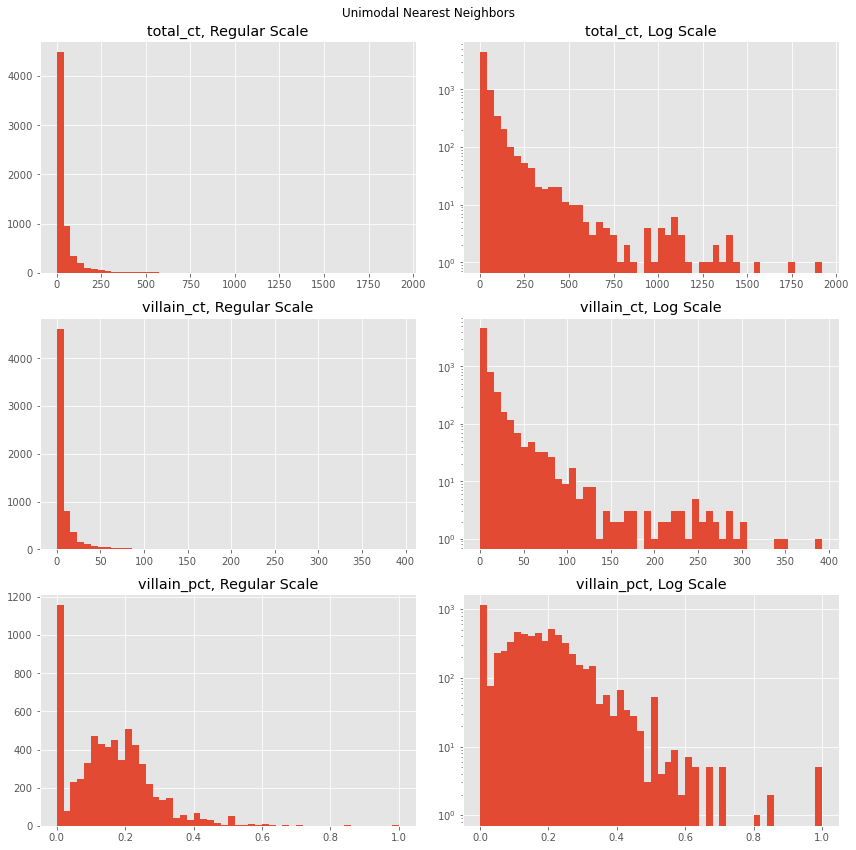

In [49]:
create_plots_sub(uni_neighbors[uni_neighbors['distance'] == 1], plot_title='Unimodal Nearest Neighbors')

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


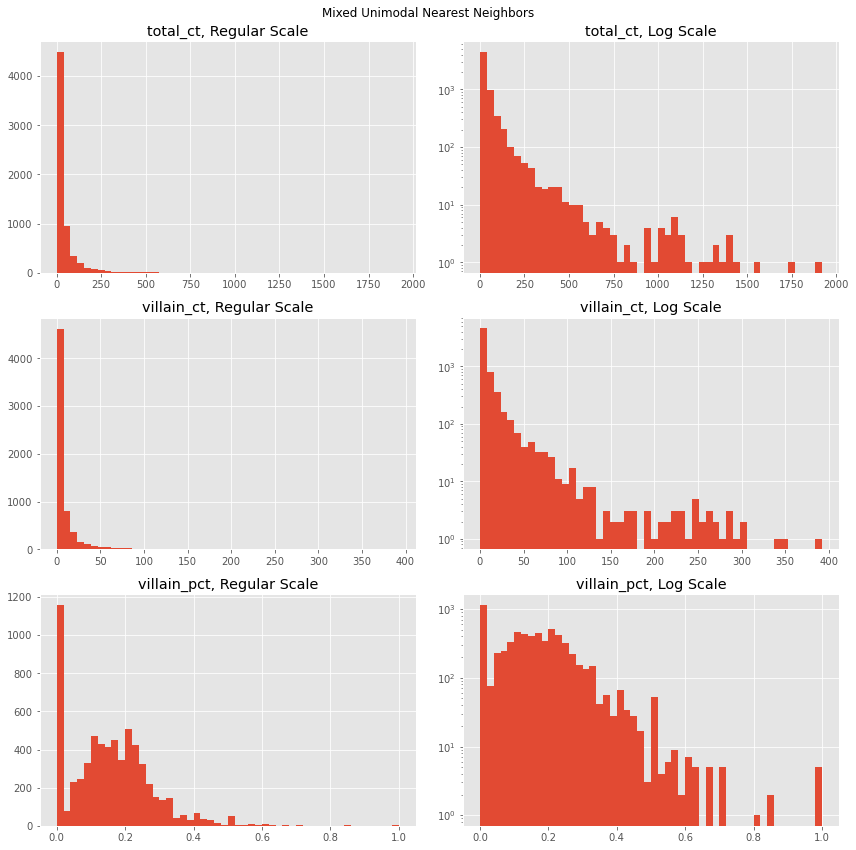

In [50]:
create_plots_sub(u_mix_neighbors[u_mix_neighbors['distance'] == 1], plot_title='Mixed Unimodal Nearest Neighbors')

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


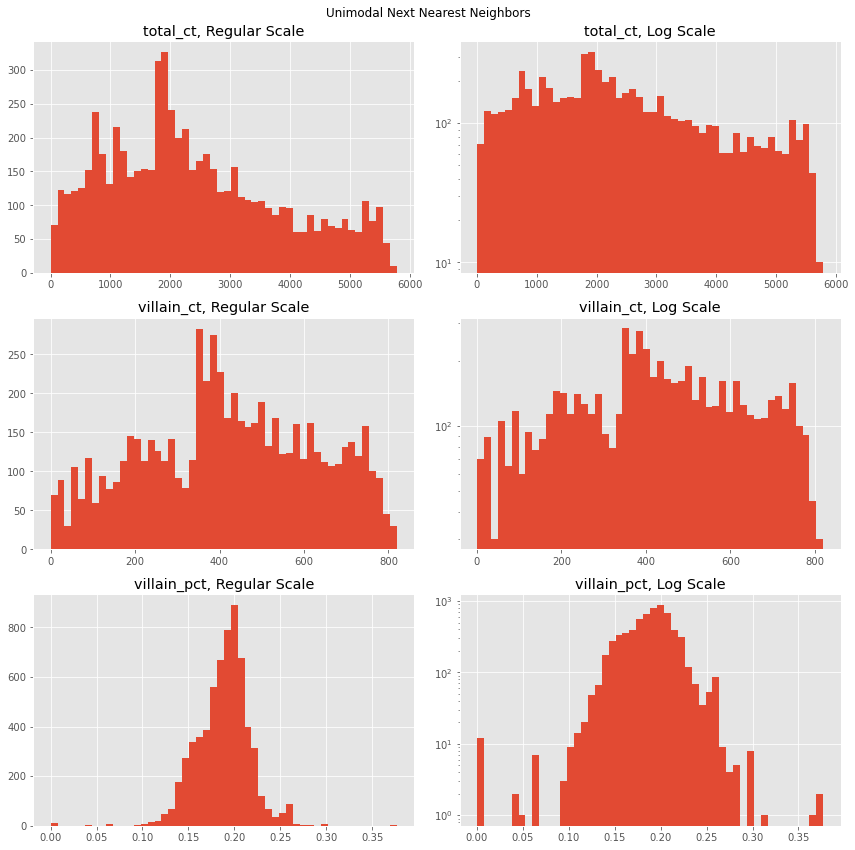

In [51]:
create_plots_sub(uni_neighbors[uni_neighbors['distance'] == 2], 'Unimodal Next Nearest Neighbors')

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


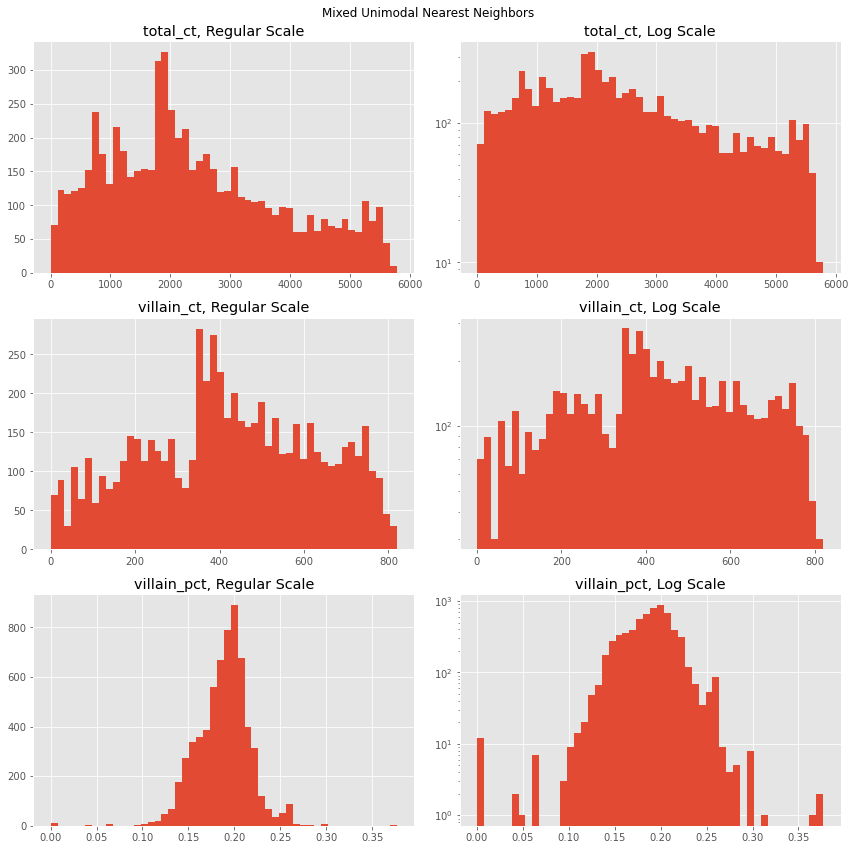

In [52]:
create_plots_sub(u_mix_neighbors[u_mix_neighbors['distance'] == 2], plot_title='Mixed Unimodal Nearest Neighbors')

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


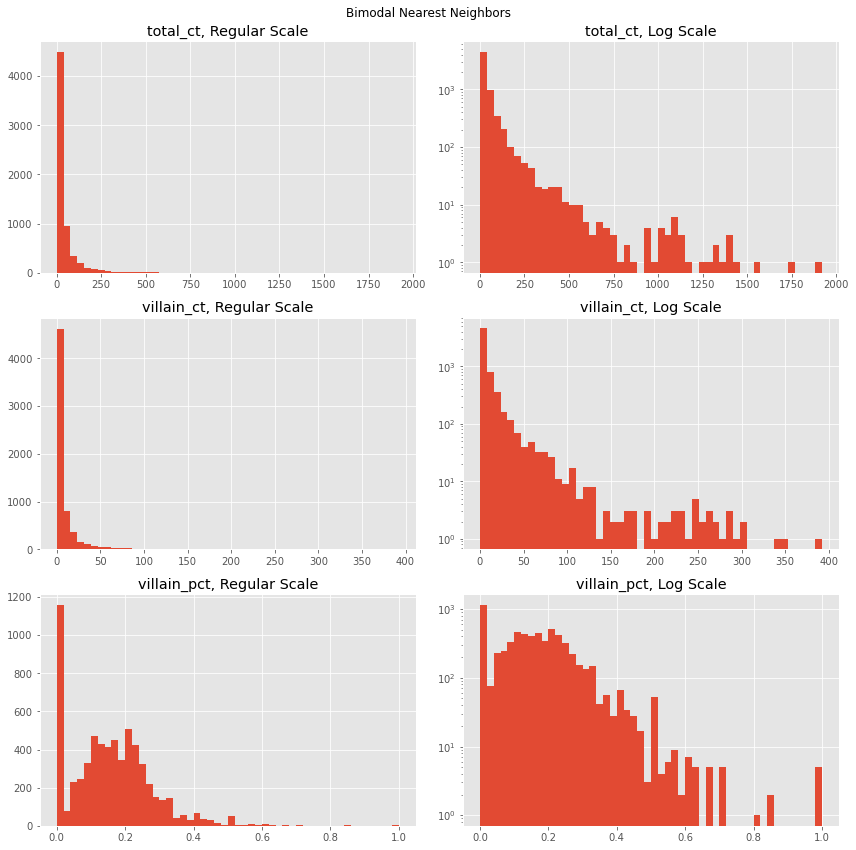

In [53]:
create_plots_sub(bi_neighbors[bi_neighbors['distance'] == 2], plot_title='Bimodal Nearest Neighbors')

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


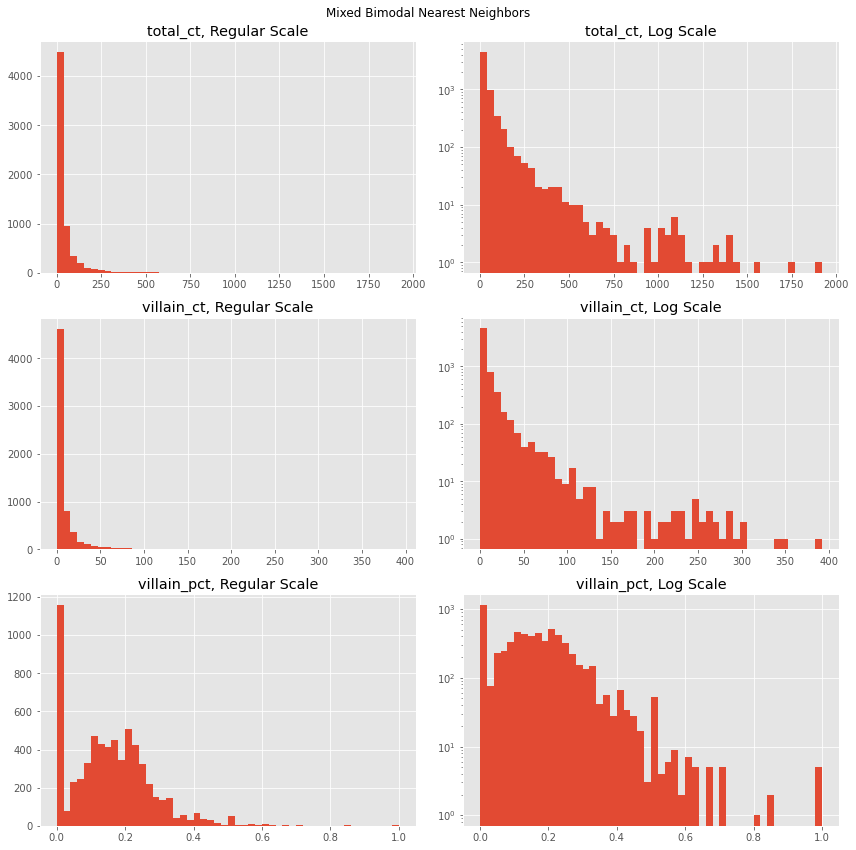

In [54]:
create_plots_sub(b_mix_neighbors[b_mix_neighbors['distance'] == 2], plot_title='Mixed Bimodal Nearest Neighbors')

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


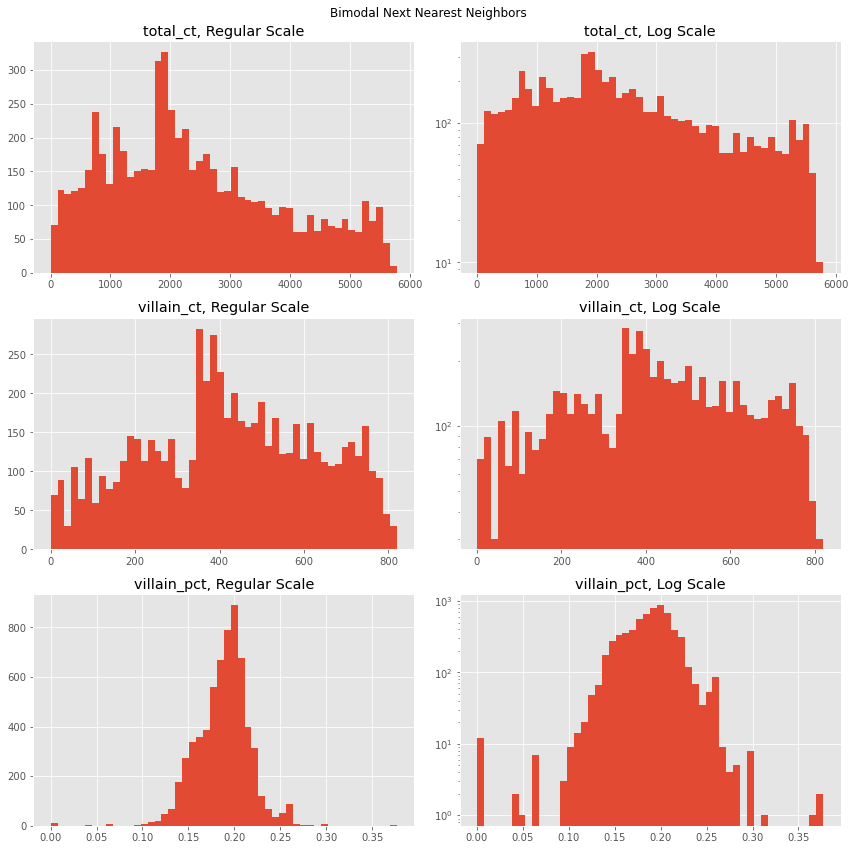

In [55]:
create_plots_sub(bi_neighbors[bi_neighbors['distance'] == 4], 'Bimodal Next Nearest Neighbors')

C:\Users\jfish\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


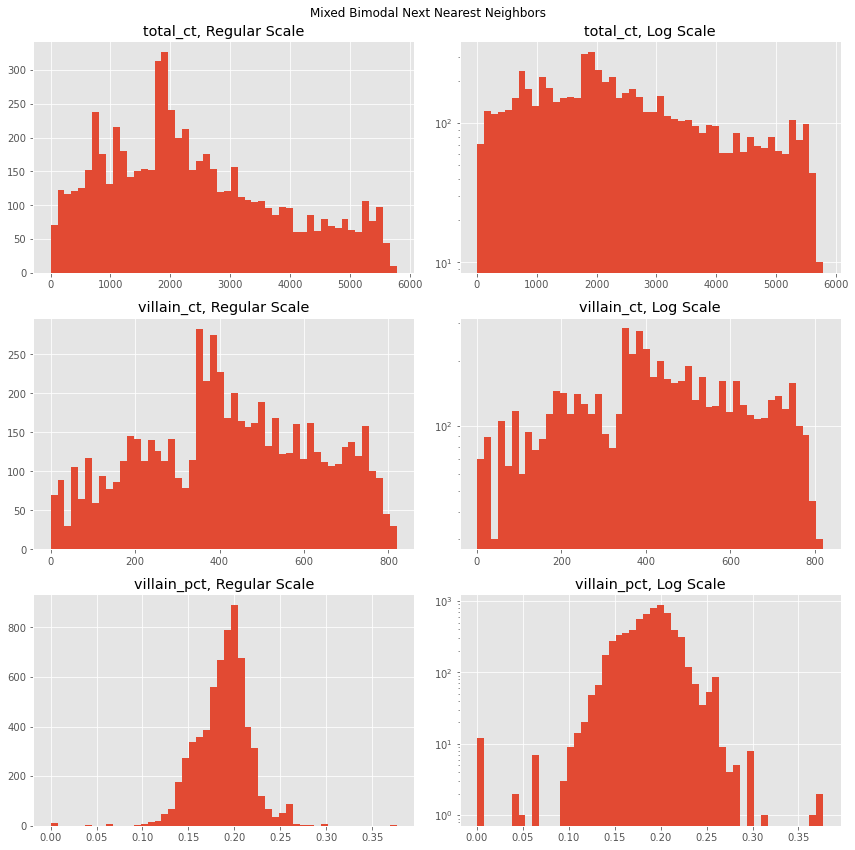

In [56]:
create_plots_sub(b_mix_neighbors[b_mix_neighbors['distance'] == 4], 'Mixed Bimodal Next Nearest Neighbors')